In [15]:
import numpy as np
import matplotlib.pyplot as plt

In [146]:
def load_model():
    nodes=np.loadtxt(r'F:\python_FEM\plane\node.txt')
    elems=np.loadtxt(r'F:\python_FEM\plane\elem.txt')
    elems=np.array(elems,dtype=int)
    fix_support=np.loadtxt(r'F:\python_FEM\plane\fixsupport.txt')
    fix_support=np.array(fix_support[:,0],dtype=int)
    force=np.loadtxt(r'F:\python_FEM\plane\force.txt')
    force=np.array(force[:,0],dtype=int)
    return nodes, elems, fix_support, force

In [147]:
nodes,elems,fix_support,force=load_model()

In [148]:
def plot_model(nodes,elems,fix_support,
               force,show_node=True,show_elem=True,show_support=True,show_force=True):
    fig1,ax1=plt.subplots()
    ax1.set_aspect('equal')
    if show_node:
        ax1.scatter(nodes[:,1],nodes[:,2],color='g')
    if show_elem:
        for elem in elems:
            node_ids = elem[1:5]
            node_ids = np.array(node_ids, dtype=int)
            coord_x = list(nodes[node_ids-1,1])
            coord_y = list(nodes[node_ids-1,2])
            plt.plot(coord_x+[coord_x[0],],coord_y+[coord_y[0],],color='k')
    if show_support:
        support_x=nodes[fix_support-1,1]
        support_y=nodes[fix_support-1,2]
        ax1.scatter(support_x,support_y,50,color='r')
    if show_force:
        force_x=nodes[force-1,1]
        force_y=nodes[force-1,2]
        ax1.scatter(force_x,force_y,50,color='b')
    plt.show()

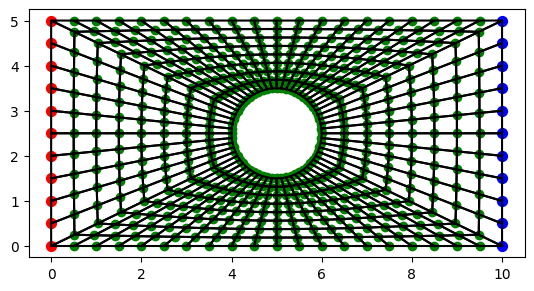

In [149]:
plot_model(nodes,elems,fix_support,force,show_node=True,show_elem=True)

In [150]:
def create_d_matrix(E, nu):
    # 确保泊松比在合理范围内
    if nu >= 1 or nu <= -1:
        raise ValueError("泊松比 nu 必须在 (-1, 1) 范围内")
    
    # 计算 D 矩阵
    d_matrix = (E / (1 - nu ** 2)) * np.array([[1, nu, 0],
                                                [nu, 1, 0],
                                                [0, 0, (1 - nu) / 2]])
    
    return d_matrix

In [151]:
D=create_d_matrix(2e10,0.3)

In [152]:
def shape_function(xi, eta):
    shape = np.zeros(4)
    deriv = np.zeros((2,4))
    shape[0]=(1-xi)*(1-eta)/4
    shape[1]=(1+xi)*(1-eta)/4
    shape[2]=(1+xi)*(1+eta)/4
    shape[3]=(1-xi)*(1+eta)/4
    
    deriv[0,0:4]=eta-1,1-eta,1+eta,-eta-1
    deriv[1,0:4]=xi-1,-xi-1,1+xi,1-xi
    deriv = deriv*0.25
    return shape, deriv #形函数和对应形函数的导数

In [153]:


# 初始化全局刚度矩阵
node_num = nodes.shape[0]
dofs = 2
global_stiffness = np.zeros((node_num * dofs, node_num * dofs))  # 全局刚度矩阵大小

for elem in elems:
    node_id = elem[1:5]  # 单元对应的节点编号
    coord_x = nodes[node_id - 1, 1]  # 第一行是从零开始的
    coord_y = nodes[node_id - 1, 2]  # 分别对应的是x和y
    coord = np.array((coord_x, coord_y))  # 节点坐标

    weight = (1, 1, 1, 1)
    xi = (-1 / np.sqrt(3), 1 / np.sqrt(3), 1 / np.sqrt(3), -1 / np.sqrt(3))
    eta = (-1 / np.sqrt(3), -1 / np.sqrt(3), 1 / np.sqrt(3), 1 / np.sqrt(3))
    K_e = np.zeros((8, 8))  # 每个单元刚度矩阵初始化

    for igp in range(4):
        shape, deriv = shape_function(xi[igp], eta[igp])  # 计算形状函数及其导数
        jacobian = deriv.dot(coord.transpose())  # 计算雅可比矩阵
        det_j = np.linalg.det(jacobian)  # 计算雅可比矩阵的行列式
        deriv = np.linalg.inv(jacobian).dot(deriv)  # 计算导数的变换

        B = np.zeros((3, 8))  # B矩阵是3行8列
        B[0, 0:8:2] = deriv[0, 0:4]
        B[1, 1:9:2] = deriv[1, 0:4]
        B[2, 0:8:2] = deriv[1, 0:4]
        B[2, 1:9:2] = deriv[0, 0:4]
        
        dvol = weight[igp] * det_j  # 体积元素
        dummy = B.T @ D @ B  # 计算当前积分点的刚度矩阵
        K_e += dummy * dvol  # 累加至单元刚度矩阵

    # 收集矩阵
    L = np.zeros((8, node_num * dofs))
    for ni in range(4):
        L[ni * 2, (node_id[ni] - 1) * 2] = 1
        L[ni * 2 + 1, (node_id[ni] - 1) * 2 + 1] = 1

    K_e2g = L.T @ K_e @ L  # 将单元刚度矩阵转化为全局坐标系
    global_stiffness += K_e2g  # 更新全局刚度矩阵

    

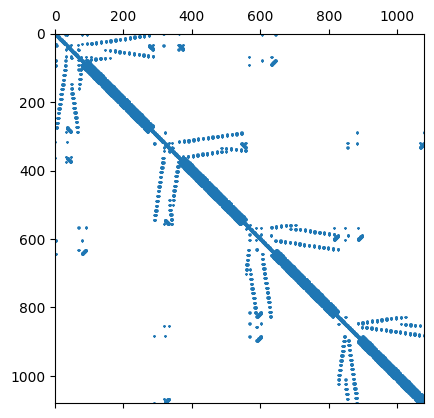

In [154]:
plt.spy(global_stiffness,marker='*',markersize=1)
plt.show()

In [155]:
#单元自由度问题，四节点单元
#节点1，Ux1和Uy1
#Ux1,Uy1,Ux2,Uy2,Ux3,Uy3,Ux4,Uy4
#荷载：100N/m 长度5m 合力500N
#中间节点受力=单元长度*100N/m
#两端节点受力=（单元长度*100N/m）/2
#单元长度=0.5m
def load():
    f = np.zeros(node_num*dofs)
    for fid in force:
        pos_x=(fid-1)*2
        f[pos_x]=0.5*100
        if fid==168 or fid==415:
            f[pos_x]=0.5*100/2
    return f


In [156]:
global_force=load()

In [157]:
#施加固定位移的约束
def apply_support():
    for fix_id in fix_support:
        pos_x=(fix_id-1)*2
        #global_stiffness[pos_x,:]=0
        #global_stiffness[:,pos_x]=0
        global_stiffness[pos_x,pos_x]*=1e5
        if fix_id==280:
            pos_y=(fix_id-1)*2+1
            global_stiffness[pos_y,pos_y]*=1e5
apply_support()

In [158]:
#计算Ku=F
nodal_disp = np.linalg.solve(global_stiffness,global_force)

In [159]:
np.savetxt('nodal_disp.txt',nodal_disp)

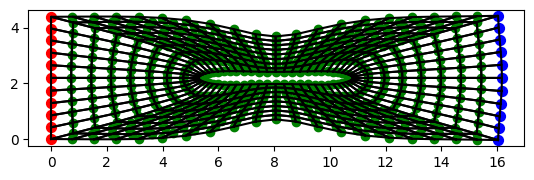

In [160]:
#更新节点坐标信息
ux_all_nodes=nodal_disp[0:nodal_disp.shape[0]:2]
uy_all_nodes=nodal_disp[1:nodal_disp.shape[0]:2]
new_nodes=np.zeros_like(nodes)
new_nodes[:,0]=nodes[:,0]
new_nodes[:,1]=nodes[:,1]+ux_all_nodes[:]*1e8
new_nodes[:,2]=nodes[:,2]+uy_all_nodes[:]*1e8
plot_model(new_nodes,elems,fix_support,force,show_node=True,show_elem=True)

In [170]:
stress = []
all_nodal_stress = np.zeros((node_num, 3))
all_nodal_stress_dict = {}

for elem in elems:
    node_id = elem[1:5]  # 单元对应的节点编号
    coord_x = nodes[node_id - 1, 1]  # 第一行是从零开始的
    coord_y = nodes[node_id - 1, 2]  # 分别对应的是x和y
    coord = np.array((coord_x, coord_y))  # 节点坐标

    weight = (1, 1, 1, 1)
    xi = (-1 / np.sqrt(3), 1 / np.sqrt(3), 1 / np.sqrt(3), -1 / np.sqrt(3))
    eta = (-1 / np.sqrt(3), -1 / np.sqrt(3), 1 / np.sqrt(3), 1 / np.sqrt(3))
    K_e = np.zeros((8, 8))  # 每个单元刚度矩阵初始化
    stress_igp = np.zeros((4, 3))
    shape_matrix = np.zeros((4, 4))

    for igp in range(4):
        shape, deriv = shape_function(xi[igp], eta[igp])  # 计算形状函数及其导数
        jacobian = deriv.dot(coord.transpose())  # 计算雅可比矩阵
        det_j = np.linalg.det(jacobian)  # 计算雅可比矩阵的行列式

        # 确保雅可比矩阵的行列式不为零
        if det_j <= 0:
            raise ValueError("雅可比矩阵的行列式为零或负值，无法进行坐标变换")

        deriv = np.linalg.inv(jacobian).dot(deriv)  # 计算导数的变换

        B = np.zeros((3, 8))  # B矩阵是3行8列
        B[0, 0:8:2] = deriv[0, 0:4]
        B[1, 1:9:2] = deriv[1, 0:4]
        B[2, 0:8:2] = deriv[1, 0:4]
        B[2, 1:9:2] = deriv[0, 0:4]

        # 计算单元的应变
        d = np.zeros(8)
        d[0:8:2] = nodal_disp[(node_id - 1) * 2]
        d[1:9:2] = nodal_disp[(node_id - 1) * 2 + 1]
        strain_igp = B.dot(d)
        stress_igp[igp, :] = D.dot(strain_igp)

        # 填充 shape_matrix
        shape_matrix[igp, :] = shape  # 每个积分点的形状函数填充到形状矩阵

    # 检查 shape_matrix 是否满秩
    if np.linalg.matrix_rank(shape_matrix.transpose().dot(shape_matrix)) < 4:
        print("形状矩阵不符合要求，使用伪逆计算")
        dummy = np.linalg.pinv(shape_matrix.transpose().dot(shape_matrix)).dot(shape_matrix.transpose())
    else:
        dummy = np.linalg.inv(shape_matrix.transpose().dot(shape_matrix)).dot(shape_matrix.transpose())
        
    nodal_stress = dummy.dot(stress_igp)
    
    for i, nid in enumerate(node_id):
        if nid in all_nodal_stress_dict:
            all_nodal_stress_dict[nid].append(nodal_stress[i])
        else:
            all_nodal_stress_dict[nid] = [nodal_stress[i]]

    for key, value in all_nodal_stress_dict.items():
        sum_stress = np.zeros(3)
        for v in value:
            sum_stress += v
        ave = sum_stress / len(value)
        all_nodal_stress[key - 1] = ave




In [161]:
print(nodes.shape)

(540, 3)


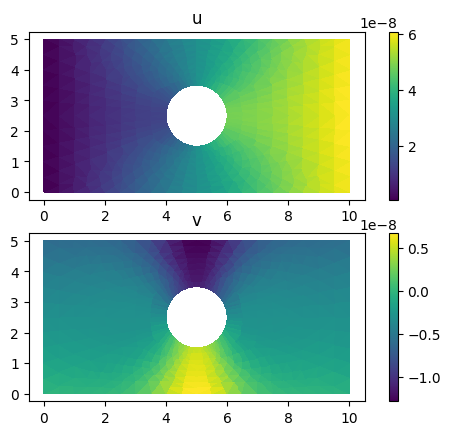

In [175]:

import matplotlib.tri as tri

# 假设 nodes 和 nodal_disp 已经定义好
# 请确保 nodes 至少有两列
coord_x_all_nodes = nodes[:, 1]  # 获取 X 坐标
coord_y_all_nodes = nodes[:, 2]  # 获取 Y 坐标
ux_all_nodes=nodal_disp[0:nodal_disp.shape[0]:2]
uy_all_nodes=nodal_disp[1:nodal_disp.shape[0]:2]

# 创建三角剖分
triang = tri.Triangulation(coord_x_all_nodes, coord_y_all_nodes)

# 设置掩码（根据特定条件）
min_radius = 1
mask = np.hypot(coord_x_all_nodes[triang.triangles] - 5, 
                coord_y_all_nodes[triang.triangles] - 2.5).mean(axis=1) < min_radius
triang.set_mask(mask)


# 创建子图
fig1, ax1 = plt.subplots(2, 1)

# 第一个图：位移在 X 方向
ax1[0].set_aspect('equal')
ax1[0].set_title('u')
tpc_u = ax1[0].tripcolor(triang, ux_all_nodes, shading='flat')  # 使用 X 方向位移
fig1.colorbar(tpc_u, ax=ax1[0])

# 第二个图：位移在 Y 方向
ax1[1].set_aspect('equal')
ax1[1].set_title('v')
tpc_v = ax1[1].tripcolor(triang, uy_all_nodes, shading='flat')  # 使用 Y 方向位移
fig1.colorbar(tpc_v, ax=ax1[1])

plt.show()


In [174]:
print(all_nodal_stress)

[[ 3.73039549e+02  4.51661601e+01 -1.23833602e-01]
 [-1.10469855e+01 -1.17245141e+02  7.97584221e-13]
 [ 3.61862973e+02  4.75591229e+01  3.07603799e+01]
 ...
 [ 6.82098839e+01  7.60799799e+00  7.25472095e+00]
 [ 4.94438819e+01  2.72590438e+00  9.38998706e+00]
 [ 3.00603541e+01 -8.37114073e+00  9.23893855e+00]]


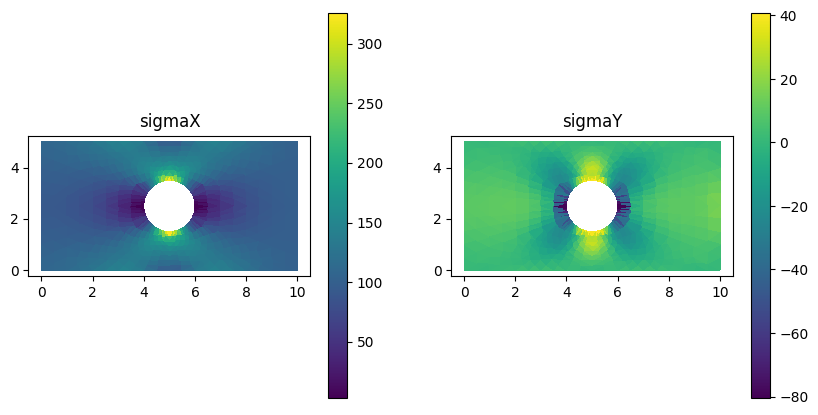

In [181]:




# 确保 nodes 至少有两列
coord_x_all_nodes = nodes[:, 1]  # 获取 X 坐标
coord_y_all_nodes = nodes[:, 2]  # 获取 Y 坐标

# 创建三角剖分
triang = tri.Triangulation(coord_x_all_nodes, coord_y_all_nodes)

# 设置掩码（根据特定条件）
min_radius = 1
mask = np.hypot(coord_x_all_nodes[triang.triangles] - 5, 
                coord_y_all_nodes[triang.triangles] - 2.5).mean(axis=1) < min_radius
triang.set_mask(mask)

# 创建图形和子图
fig1, ax1 = plt.subplots(1, 2, figsize=(10, 5))

ax1[0].set_aspect('equal')
ax1[0].set_title('sigmaX')
tpc_u = ax1[0].tripcolor(triang, all_nodal_stress[:, 0], shading='flat')  # 使用 X 方向位移
fig1.colorbar(tpc_u, ax=ax1[0])

ax1[1].set_aspect('equal')
ax1[1].set_title('sigmaY')
tpc_v = ax1[1].tripcolor(triang, all_nodal_stress[:, 1], shading='flat')  # 使用 Y 方向位移
fig1.colorbar(tpc_v, ax=ax1[1])

plt.show()
